Install requirements

In [1]:
! pip install -Uqq fastcore
! pip install -Uqq kaggle --force
! pip freeze | grep fastcore

     |████████████████████████████████| 56 kB 2.6 MB/s 
     |████████████████████████████████| 58 kB 2.5 MB/s 
     |████████████████████████████████| 149 kB 9.7 MB/s 
     |████████████████████████████████| 247 kB 6.2 MB/s 
     |████████████████████████████████| 63 kB 938 kB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 138 kB 27.5 MB/s 
     |████████████████████████████████| 78 kB 5.3 MB/s 
     |████████████████████████████████| 61 kB 3.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0

In [2]:
from IPython.display import display

In [3]:
import os
from pathlib import Path
import random
from collections import OrderedDict, Counter

In [4]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm 

In [5]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.xtras import *
from fastcore.basics import noop

In [7]:
np.random.seed(1)

# Get data from Kaggle

In [8]:
# kaggle.json key placed in /content/drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'

In [10]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [03:19<00:00, 64.3MB/s]
100% 9.51G/9.51G [03:19<00:00, 51.1MB/s]


In [11]:
! unzip -q aptos2019-blindness-detection.zip

# Explore data

In [12]:
train_df = pd.read_csv('train.csv')

In [13]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


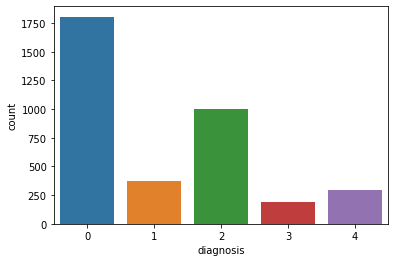

In [14]:
sns.countplot(data=train_df, x="diagnosis")

In [15]:
train_pth = Path('train_images')
test_pth = Path('test_images')

In [16]:
train_fns = train_pth.ls()
test_fns = test_pth.ls()
train_fns, test_fns

((#3662) [Path('train_images/22325552a4e3.png'),Path('train_images/a81b06f50612.png'),Path('train_images/3254e48c8aa0.png'),Path('train_images/dee31065f8fe.png'),Path('train_images/20d5fdd450ae.png'),Path('train_images/a1e236fbc863.png'),Path('train_images/cd4e7f9fa1a9.png'),Path('train_images/7c2e852171c0.png'),Path('train_images/0a61bddab956.png'),Path('train_images/e4730ddde408.png')...],
 (#1928) [Path('test_images/689d5626e98a.png'),Path('test_images/49cb7972e2a2.png'),Path('test_images/a6276ef5053b.png'),Path('test_images/132e1876157b.png'),Path('test_images/437fa52cb1cb.png'),Path('test_images/99b0bee3bca7.png'),Path('test_images/4c70b2944d9e.png'),Path('test_images/2cfc3041caca.png'),Path('test_images/de491c9a3896.png'),Path('test_images/c39d7fde814c.png')...])

# Show a set of 2 images at random for each class

In [17]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


Choose 3 random images based on `id_code`

In [18]:
cls=0
random.choices(train_df[train_df.diagnosis==cls].id_code.to_list(), k=3)

['393fa5a023a5', '486e852a3b4d', 'b9c7c5182075']

In [19]:
def open_img(img_id, pth:Path, ext='png', cspace='RGB', sz=None):
  """Read image from path given the image_id."""
  img_pth = pth/f'{img_id}.{ext}'
  img = Image.open(img_pth).convert(cspace)
  img = img if sz is None else img.resize((sz, sz))
  return np.asarray(img)

In [20]:
img = open_img('000c1434d8d7', train_pth, sz=224)
img.shape

(224, 224, 3)

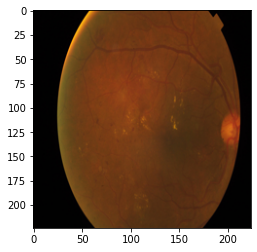

In [21]:
plt.imshow(img)

In [22]:
def annotate_axes(ax, text, fontsize=10, x=0., y=1.1):
  """Add annotations to ax object."""
  ax.text(x, y, text, transform=ax.transAxes,
          va="center", fontsize=fontsize, color="gray")

In [23]:
vocab = OrderedDict(NoDR=0, Mild=1, Moderate=2, Severe=3, ProliferativeDR=4)
vocab

OrderedDict([('NoDR', 0),
             ('Mild', 1),
             ('Moderate', 2),
             ('Severe', 3),
             ('ProliferativeDR', 4)])

In [24]:
vocab.keys()

odict_keys(['NoDR', 'Mild', 'Moderate', 'Severe', 'ProliferativeDR'])

In [25]:
def show_imgs(df, vocab=None, n_cols=5, n_rows=5, figsize=(10,8), sz=224):
  """Show a set of random images for each class"""
  fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
  for cls, ax in enumerate(axs):
    data_ls = df[df.diagnosis==cls].id_code.to_list()
    fns = random.choices(data_ls, k=n_cols)
    # print(fns, cls)
    for i in range(n_cols):
      img = open_img(fns[i], train_pth, sz=sz)
      im = ax[i].imshow(img)
      ax[i].axis('off')
      text = f'class: {cls}' if vocab is None else L(vocab.keys())[cls]
      annotate_axes(ax[i], text)
    plt.tight_layout()
  plt.show()

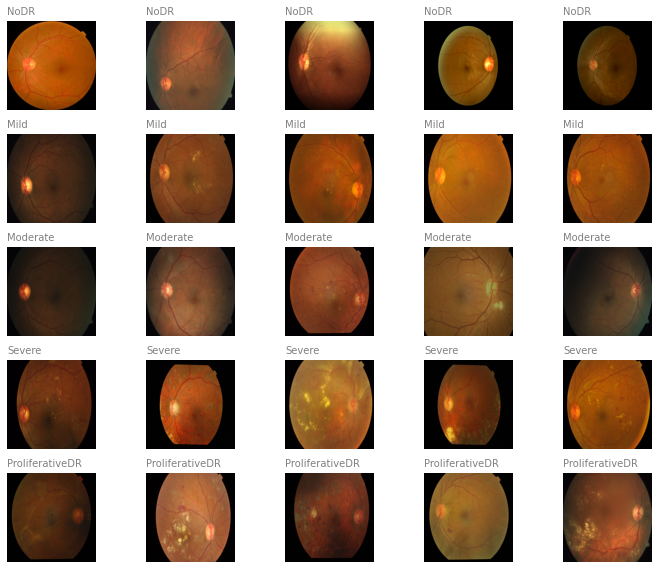

In [26]:
show_imgs(train_df, vocab)

# Check images per class

In [27]:
counts = train_df.diagnosis.value_counts()

In [28]:
counts

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

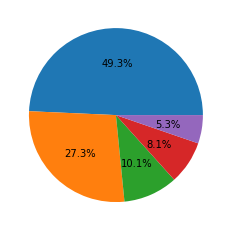

In [29]:
ax = plt.pie(counts, autopct="%.1f%%")

In [30]:
vocab

OrderedDict([('NoDR', 0),
             ('Mild', 1),
             ('Moderate', 2),
             ('Severe', 3),
             ('ProliferativeDR', 4)])

In [31]:
"""
# Manually undersample
block_list = DefaultDict(lambda: False)
counter = DefaultDict(lambda: 0)
new_df = {'id_code': [],
          'diagnosis': [],}

for idx, row in train_df.iterrows():
  if row.diagnosis not in block_list:
    counter[row.diagnosis]+=1
    new_df['id_code'].extend([row.id_code])
    new_df['diagnosis'].extend([row.diagnosis])
  if counter[row.diagnosis] >= 250:
    block_list[row.diagnosis] = True
"""

"\n# Manually undersample\nblock_list = DefaultDict(lambda: False)\ncounter = DefaultDict(lambda: 0)\nnew_df = {'id_code': [],\n          'diagnosis': [],}\n\nfor idx, row in train_df.iterrows():\n  if row.diagnosis not in block_list:\n    counter[row.diagnosis]+=1\n    new_df['id_code'].extend([row.id_code])\n    new_df['diagnosis'].extend([row.diagnosis])\n  if counter[row.diagnosis] >= 250:\n    block_list[row.diagnosis] = True\n"

Assign weights to each sample.

In [32]:
weights = counts/counts.sum()
weights

0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64

In [33]:
-np.log(weights)

0    0.707449
2    1.299010
1    2.292262
4    2.518789
3    2.943075
Name: diagnosis, dtype: float64

In [34]:
train_df["weights"] = train_df.diagnosis.apply(lambda x: -np.log(weights[x]))

# Make train, valid test

In [35]:
train_df.head()

,id_code,diagnosis,weights
0,000c1434d8d7,2,1.299010
1,001639a390f0,4,2.518789
2,0024cdab0c1e,1,2.292262
3,002c21358ce6,0,0.707449
4,005b95c28852,0,0.707449


In [36]:
tmp = train_df.sample(frac=1, replace=False) # shuffle

Split train and valid and then based on class.

In [37]:
data = tmp.to_records(index=False)

In [38]:
len(data)

3662

array(['c40976189f22', '5723d0ec895e', '07e827469099', ...,
       '6733544ae7a6', '5777ef74c9ec', '6cdd0f985270'], dtype=object)

In [39]:
train_data = data[:3000]
valid_data = data[3000:]

In [59]:
train_data.id_code

array(['c40976189f22', '5723d0ec895e', '07e827469099', ...,
       '6733544ae7a6', '5777ef74c9ec', '6cdd0f985270'], dtype=object)

In [40]:
len(train_data), len(valid_data)

(3000, 662)

# Make Dataset

In [41]:
import torchvision.transforms as T
import torch
from torchvision import models

In [43]:
# imagenet_stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [44]:
def train_augs():
  """Training augmentation"""
  return T.Compose([
                    T.ToTensor(),
                    T.Resize(300),
                    T.RandomAdjustSharpness(1.2),
                    T.RandomHorizontalFlip(),
                    T.ColorJitter(),
                    T.Normalize(mean=mean, std=std),])

def valid_augs():
  """Validation augmentation"""
  return T.Compose([
                    T.ToTensor(),
                    T.Resize(300),
                    T.Normalize(mean=mean, std=std),])

In [45]:
class APTOSDataset(torch.utils.data.Dataset):
  def __init__(self, data, pth, augs=None, sz=300, test=False):
    super(APTOSDataset, self).__init__()
    self.data = data
    self.pth = pth
    self.augs = augs() if augs is not None else False
    self.sz = sz
    self.test = test
  
  def __getitem__(self, idx):
    label = None
    img = open_img(self.data[idx][0], self.pth, sz=self.sz)
    if not self.test:
      label = self.data[idx][1]
      label = torch.tensor([label], dtype=torch.long)
    if self.augs:
      img = self.augs(img)
    return img, label
  
  def __len__(self):
    return len(self.data)

In [46]:
APTOSDataset(train_data, pth=train_pth)

In [47]:
train_ds = APTOSDataset(train_data, pth=train_pth, augs=train_augs)

In [48]:
train_ds[1]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:126: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)



(tensor([[[-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          ...,
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494]],
 
         [[-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9832, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          ...,
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657]],
 
         [[-1.6999, -1.6999, -1.6999,  ..., -1.6999, -1.6999, -1.6999],
          [-1.6999, -1.6999,

In [49]:
valid_ds = APTOSDataset(valid_data, pth=train_pth, augs=valid_augs)

In [50]:
valid_ds[100]

(tensor([[[-2.0837, -2.0665, -2.0665,  ..., -2.0665, -2.0837, -2.0665],
          [-2.0665, -2.0837, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0837, -2.0665,  ..., -2.0837, -2.0665, -2.0837],
          ...,
          [-2.1008, -2.1008, -2.0837,  ..., -2.1008, -2.0837, -2.1008],
          [-2.0837, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.0837, -2.0665,  ..., -2.1008, -2.1008, -2.1008]],
 
         [[-2.0357, -2.0182, -2.0182,  ..., -2.0182, -2.0357, -2.0182],
          [-2.0182, -2.0357, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0357, -2.0182,  ..., -2.0357, -2.0182, -2.0357],
          ...,
          [-2.0182, -2.0182, -2.0007,  ..., -2.0182, -2.0007, -2.0182],
          [-2.0007, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],
 
         [[-1.7870, -1.7696, -1.7696,  ..., -1.7696, -1.7870, -1.7696],
          [-1.7696, -1.7870,

# Make DataLoader

In [51]:
bs=64

In [52]:
len(train_ds)/bs, len(valid_ds)/bs

(46.875, 10.34375)

In [53]:
drop_last=True

In [63]:
train_sampler = torch.utils.data.WeightedRandomSampler(weights=train_data.weights, num_samples=len(train_ds))
valid_sampler = torch.utils.data.WeightedRandomSampler(weights=valid_data.weights, num_samples=len(valid_ds))

In [64]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, drop_last=drop_last, 
                                       sampler=train_sampler)

In [65]:
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, drop_last=drop_last, 
                                       sampler=valid_sampler)

In [66]:
print(f'train dblock len: {len(train_dl)}')
print(f'valid dblock len: {len(valid_dl)}')

train dblock len: 46
valid dblock len: 10


Make a sample batch.

In [67]:
for i, (img, label) in enumerate(train_dl):
    break

In [68]:
img.shape, label.shape

(torch.Size([64, 3, 300, 300]), torch.Size([64, 1]))

Check if the samples were correctly chosen.

In [69]:
counts

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [70]:
Counter(label.squeeze().tolist())

Counter({0: 15, 1: 15, 2: 14, 3: 7, 4: 13})

# Build Residual block from scratch
![](https://d2l.ai/_images/resnet-block.svg)

L: Identity/Regular Block

R: Convolutional Block

In [71]:
from torch import nn
import torch.nn.functional as F

Random tensor to test the implementation.

In [72]:
x = torch.rand(4, 3, 6, 6)
x.shape

torch.Size([4, 3, 6, 6])

## Making the common block

`ConvBnAct`: Apply `Conv2D`, `BatchNorm2d` and `ReLu` in sequence.

In [73]:
class ConvBnAct(nn.Module):
  """Calls `Conv2D`, `BatchNorm2d` and `act_fn` in sequence.
  `noop` with `bn=False`, `act=False`.
  """
  def __init__(self, in_ch=3, out_ch=64, k=3, s=1, p=0, d=1, bn=True, act=True):
    super(ConvBnAct, self).__init__()
    store_attr('in_ch, out_ch, k, s, p, d, bn, act', self)
    self.conv = nn.Conv2d(self.in_ch, self.out_ch, self.k, self.s, self.p, self.d, bias=False)
    self.bn = nn.BatchNorm2d(self.out_ch) if self.bn else noop
    self.act_fn = nn.ReLU() if self.act else noop
  def forward(self, x):
    x = self.bn(self.conv(x))
    return self.act_fn(x)

In [74]:
params = dict(in_ch=3, out_ch=64, k=7, s=2, p=3)

In [75]:
ConvBnAct(**params)(x).shape

torch.Size([4, 64, 3, 3])

## Making the RegularBlock and ConvBlock 

In [76]:
class RegularBlock(nn.Module):
  """Regular block (no 1x1conv). 
  Adds the input to the output before applying the final act_fn.
  """
  def __init__(self, in_ch, out_ch):
    super(RegularBlock, self).__init__()
    assert in_ch==out_ch, "Regular block should have in_ch==out_ch"
    self.conv1 = ConvBnAct(in_ch=in_ch, out_ch=out_ch, k=3, s=1, p=1)
    self.conv2 = ConvBnAct(in_ch=out_ch, out_ch=out_ch, k=3, s=1, p=1, act=False)
  def forward(self, x):
    x_copy = x.clone()
    x = self.conv1(x)
    x = self.conv2(x) 
    # print(x.shape, x_copy.shape)
    out = F.relu(x + x_copy)
    # print(out.shape)
    return out

In [77]:
RegularBlock(3, 3)(x).shape

torch.Size([4, 3, 6, 6])

In [78]:
class ConvBlock(nn.Module):
  """ConvBlock (with 1x1conv). 
  Adds the 1x1 conv input to the output before applying the final act_fn.
  """
  def __init__(self, in_ch, out_ch, s=1):
    super(ConvBlock, self).__init__()
    self.conv1 = ConvBnAct(in_ch=in_ch, out_ch=out_ch, k=3, s=s, p=1)
    self.conv2 = ConvBnAct(in_ch=out_ch, out_ch=out_ch, k=3, p=1, act=False)
    self.dsample = ConvBnAct(in_ch=in_ch, out_ch=out_ch, k=1, s=s, act=False)
  def forward(self, x):
    x_copy = x.clone()
    x = self.conv1(x)
    x = self.conv2(x) 
    x_copy = self.dsample(x_copy)
    # print(x.shape, x_copy.shape)
    out = F.relu(x + x_copy)
    # print(out.shape)
    return out

In [79]:
ConvBlock(3, 6, s=2)(x).shape

torch.Size([4, 6, 3, 3])

## First Layer of ResNet18

In [80]:
x = torch.randn(5, 3, 32, 32)

In [81]:
params = dict(in_ch=3, out_ch=64, k=7, s=2, p=3)

In [82]:
ConvBnAct(**params)(x).shape

torch.Size([5, 64, 16, 16])

In [83]:
l1 = nn.Sequential(ConvBnAct(**params), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [84]:
acts = l1(x)
acts.shape

torch.Size([5, 64, 8, 8])

## Residual Blocks 
Consists of Several combinations of ConvBlock and RegularBlocks. The first ResBlock does not have ConvBlock. The following ResBlocks have a combination of ConvBlock followed by RegularBlock.

![](https://d2l.ai/_images/resnet18.svg)

In [85]:
def resnet_block(in_ch, out_ch, n_blocks, first_block=False):
  """Helper function to customize the number of blocks in the resnet."""
  layers = []
  names = []
  for i in range(n_blocks):
    if i == 0 and not first_block:
      layers.append(ConvBlock(in_ch, out_ch, s=2))
      names.append(f'conv_blk{i}')
    else:
      layers.append(RegularBlock(out_ch, out_ch))
      names.append(f'reg_blk{i}')
  return list(zip(names, layers))

In [86]:
resnet_block(64, 64, 2, first_block=False)

[('conv_blk0', ConvBlock(
    (conv1): ConvBnAct(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU()
    )
    (conv2): ConvBnAct(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dsample): ConvBnAct(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )), ('reg_blk1', RegularBlock(
    (conv1): ConvBnAct(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU()
    )
    (conv2): ConvBnAct(
      (conv): Conv2d(64, 64, 

In [87]:
l2 = nn.Sequential(OrderedDict(resnet_block(64, 64, 2, first_block=True)))
l3 = nn.Sequential(OrderedDict(resnet_block(64, 128, 2)))
l4 = nn.Sequential(OrderedDict(resnet_block(128, 256, 2)))
l5 = nn.Sequential(OrderedDict(resnet_block(256, 512, 2)))

In [88]:
l5

Sequential(
  (conv_blk0): ConvBlock(
    (conv1): ConvBnAct(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU()
    )
    (conv2): ConvBnAct(
      (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dsample): ConvBnAct(
      (conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (reg_blk1): RegularBlock(
    (conv1): ConvBnAct(
      (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): ReLU()
    )
    (conv2): ConvBnAct(
      

In [89]:
l2(acts).shape

torch.Size([5, 64, 8, 8])

In [90]:
acts = l5(l4(l3(l2(acts))))

## Final Linear layer

In [91]:
vocab

OrderedDict([('NoDR', 0),
             ('Mild', 1),
             ('Moderate', 2),
             ('Severe', 3),
             ('ProliferativeDR', 4)])

In [92]:
len(vocab)

5

In [93]:
fc = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), 
                   nn.Flatten(), 
                   nn.Linear(512, len(vocab)))

In [94]:
fc(acts).shape

torch.Size([5, 5])

# Putting the blocks together

In [95]:
class ResNet18(nn.Module):
  def __init__(self, n_cls=2):
    super(ResNet18, self).__init__()
    params = dict(in_ch=3, out_ch=64, k=7, s=2, p=3)                                # GoogLeNet
                                                                                    # x = [B, 3, 32, 32]
    self.l1 = nn.Sequential(ConvBnAct(**params), 
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))       # -> [B, 512, 16, 16]
    self.l2 = nn.Sequential(OrderedDict(resnet_block(64, 64, 2, first_block=True))) # -> [B, 64, 8, 8]
    self.l3 = nn.Sequential(OrderedDict(resnet_block(64, 128, 2)))                  # -> [B, 128, 4, 4]
    self.l4 = nn.Sequential(OrderedDict(resnet_block(128, 256, 2)))                 # -> [B, 256, 2, 2]
    self.l5 = nn.Sequential(OrderedDict(resnet_block(256, 512, 2)))                 # -> [B, 512, 1, 1]
    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.flat = nn.Flatten()
    self.fc = nn.Linear(512, n_cls)                                                 # -> [512, n_cls]
  def forward(self, x):
    x = self.l5(self.l4(self.l3(self.l2(self.l1(x)))))
    return self.fc(self.flat(self.pool(x)))

In [96]:
model = ResNet18(len(vocab))

In [97]:
logits = model(x)
# logits

In [98]:
# torch.softmax(logits, -1).argmax(-1, keepdim=True)

## Comparing with the size of torch implementation of `resnet18` with `n_cls=1000`

In [99]:
torch_model = models.resnet18()

In [100]:
sum([p.nelement()*p.element_size() for p in torch_model.parameters()])/1024/1024 # 44MB

44.591949462890625

In [101]:
sum([p.nelement()*p.element_size() for p in ResNet18(1000).parameters()])/1024/1024 # 44MB 

44.591949462890625

# Load the weights 
Update the weights of the model with imagenet weights from torch.models

In [102]:
model.l1[0]

ConvBnAct(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn): ReLU()
)

In [103]:
L(model.l1[0].parameters())[0] = torch_model.conv1.weight # conv1 weight
L(model.l1[0].parameters())[1] = torch_model.bn1.weight # bn1 weight

In [104]:
L(model.l2.reg_blk0.conv1.parameters())[0] = torch_model.layer1[0].conv1.weight
L(model.l2.reg_blk0.conv1.parameters())[1] = torch_model.layer1[0].bn1.weight
L(model.l2.reg_blk0.conv2.parameters())[0] = torch_model.layer1[0].conv2.weight
L(model.l2.reg_blk0.conv2.parameters())[1] = torch_model.layer1[0].bn2.weight
#
L(model.l2.reg_blk1.conv1.parameters())[0] = torch_model.layer1[1].conv1.weight
L(model.l2.reg_blk1.conv1.parameters())[1] = torch_model.layer1[1].bn1.weight
L(model.l2.reg_blk1.conv2.parameters())[0] = torch_model.layer1[1].conv2.weight
L(model.l2.reg_blk1.conv2.parameters())[1] = torch_model.layer1[1].bn2.weight

In [105]:
L(model.l3.conv_blk0.conv1.parameters())[0] = torch_model.layer2[0].conv1.weight
L(model.l3.conv_blk0.conv1.parameters())[1] = torch_model.layer2[0].bn1.weight
L(model.l3.conv_blk0.conv2.parameters())[0] = torch_model.layer2[0].conv2.weight
L(model.l3.conv_blk0.conv2.parameters())[1] = torch_model.layer2[0].bn2.weight
L(model.l3.conv_blk0.dsample.parameters())[0] = torch_model.layer2[0].downsample[0].weight
L(model.l3.conv_blk0.dsample.parameters())[1] = torch_model.layer2[0].downsample[1].weight
#
L(model.l3.reg_blk1.conv1.parameters())[0] = torch_model.layer2[1].conv1.weight
L(model.l3.reg_blk1.conv1.parameters())[1] = torch_model.layer2[1].bn1.weight
L(model.l3.reg_blk1.conv2.parameters())[0] = torch_model.layer2[1].conv2.weight
L(model.l3.reg_blk1.conv2.parameters())[1] = torch_model.layer2[1].bn2.weight

In [106]:
L(model.l4.conv_blk0.conv1.parameters())[0] = torch_model.layer3[0].conv1.weight
L(model.l4.conv_blk0.conv1.parameters())[1] = torch_model.layer3[0].bn1.weight
L(model.l4.conv_blk0.conv2.parameters())[0] = torch_model.layer3[0].conv2.weight
L(model.l4.conv_blk0.conv2.parameters())[1] = torch_model.layer3[0].bn2.weight
L(model.l4.conv_blk0.dsample.parameters())[0] = torch_model.layer3[0].downsample[0].weight
L(model.l4.conv_blk0.dsample.parameters())[1] = torch_model.layer3[0].downsample[1].weight
#
L(model.l4.reg_blk1.conv1.parameters())[0] = torch_model.layer3[1].conv1.weight
L(model.l4.reg_blk1.conv1.parameters())[1] = torch_model.layer3[1].bn1.weight
L(model.l4.reg_blk1.conv2.parameters())[0] = torch_model.layer3[1].conv2.weight
L(model.l4.reg_blk1.conv2.parameters())[1] = torch_model.layer3[1].bn2.weight

In [107]:
L(model.l5.conv_blk0.conv1.parameters())[0] = torch_model.layer4[0].conv1.weight
L(model.l5.conv_blk0.conv1.parameters())[1] = torch_model.layer4[0].bn1.weight
L(model.l5.conv_blk0.conv2.parameters())[0] = torch_model.layer4[0].conv2.weight
L(model.l5.conv_blk0.conv2.parameters())[1] = torch_model.layer4[0].bn2.weight
L(model.l5.conv_blk0.dsample.parameters())[0] = torch_model.layer4[0].downsample[0].weight
L(model.l5.conv_blk0.dsample.parameters())[1] = torch_model.layer4[0].downsample[1].weight
#
L(model.l5.reg_blk1.conv1.parameters())[0] = torch_model.layer4[1].conv1.weight
L(model.l5.reg_blk1.conv1.parameters())[1] = torch_model.layer4[1].bn1.weight
L(model.l5.reg_blk1.conv2.parameters())[0] = torch_model.layer4[1].conv2.weight
L(model.l5.reg_blk1.conv2.parameters())[1] = torch_model.layer4[1].bn2.weight

# Test model

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [109]:
model = model.to(device)

In [110]:
loss_func = torch.nn.CrossEntropyLoss()

In [111]:
images, labels = next(iter(train_dl))
acts = model(images.to(device))

In [112]:
Counter(label.squeeze().tolist())

Counter({0: 15, 1: 15, 2: 14, 3: 7, 4: 13})

In [113]:
preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)

In [114]:
Counter(preds.squeeze().tolist())

Counter({4: 64})

In [115]:
loss_func(acts, labels.to(device).squeeze())

tensor(1.6556, device='cuda:0', grad_fn=<NllLossBackward0>)

In [116]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# Begin training

In [117]:
def show_images(images, labels=None, preds=None, ncols=2, nrows=3, mean=mean, std=std):
  """Show method to display images from the dataloader batch."""
  plt.figure(figsize=(8,6))
  images = images.permute(0,2,3,1).detach().cpu().numpy()
  mean=np.array(mean)
  std=np.array(std)
  for i, image in enumerate(images):
    plt.subplot(ncols, nrows, i+1, xticks=[], yticks=[])
    image = image * std + mean
    if preds is not None and labels is not None:
      col = 'green' if preds[i]==labels[i] else 'red'
      true_label = f'{labels[i].detach().cpu().numpy()}'
      pred_label = f'{preds[i].detach().cpu().numpy()}'
      plt.xlabel(true_label)
      plt.ylabel(pred_label, color=col)
    plt.imshow(image.clip(0, 255))
    
  plt.tight_layout()
  plt.show()

In [118]:
x, y = next(iter(train_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


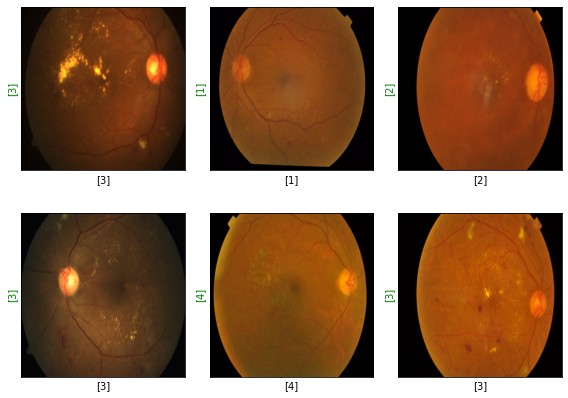

In [119]:
show_images(x[:6], labels=y[:6], preds=y[:6])

In [120]:
def show_preds(dl, limit=6, **kwargs):
  """Method to show predictions for a batch from dataloader."""
  model.eval()
  images, labels = next(iter(dl))
  images, labels = images.to(device), labels.to(device)
  acts = model(images)
  preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
  show_images(images[:limit], labels[:limit], preds[:limit], **kwargs)

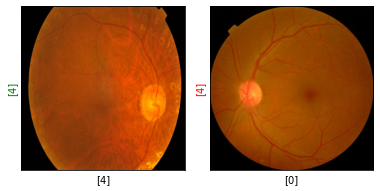

In [121]:
show_preds(train_dl, 2)

# Begin Training

In [122]:
@torch.no_grad()
def validate_epoch(valid_dl, model, loss_func=loss_func, show=True):
  model.eval()
  l_valid = len(valid_dl)
  valid_loss = 0.0
  valid_acc = 0.0
  for vb, (images, labels) in enumerate(tqdm(valid_dl)):
    images, labels = images.to(device), labels.to(device)
    acts = model(images)
    loss = loss_func(acts, labels.squeeze())
    valid_loss += loss.item()
    preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
    valid_acc += (preds==labels).float().mean().item()
  tqdm.write(f'valid_acc:{(valid_acc/l_valid):.4f} valid_loss:{(valid_loss/l_valid):.4f}')
  if show:
    show_preds(valid_dl, 3)

In [123]:
def train(train_dl, valid_dl, epochs):
  for e in range(epochs):
    print(f'epoch {e}')
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    l_train = len(train_dl)
    for tb, (images, labels) in enumerate(tqdm(train_dl)):
      images, labels = images.to(device), labels.to(device)
      acts = model(images)
      # opt
      optim.zero_grad()
      # loss
      loss = loss_func(acts, labels.squeeze())
      train_loss += loss.item()
      loss.backward()
      optim.step()
      # preds train
      preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
      train_acc += (preds==labels).float().mean().item()
    
    tqdm.write(f'train_acc:{(train_acc/l_train):.4f} train_loss:{(train_loss/l_train):.4f}')
    if e%2==0:
      # validate every 2 epochs
      validate_epoch(valid_dl, model, loss_func=loss_func, show=True)
    

epoch 0


100%|██████████| 46/46 [09:34<00:00, 12.49s/it]


train_acc:0.4623 train_loss:1.3609


100%|██████████| 10/10 [01:48<00:00, 10.84s/it]


valid_acc:0.2891 valid_loss:3.6220


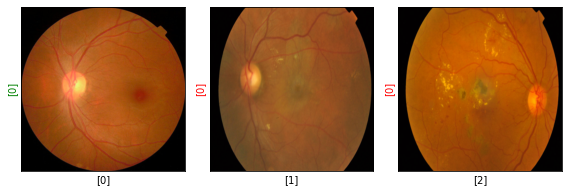

epoch 1


100%|██████████| 46/46 [09:10<00:00, 11.98s/it]


train_acc:0.5102 train_loss:1.1769
epoch 2


100%|██████████| 46/46 [08:48<00:00, 11.50s/it]


train_acc:0.5299 train_loss:1.1467


100%|██████████| 10/10 [01:43<00:00, 10.31s/it]


valid_acc:0.3953 valid_loss:2.3696


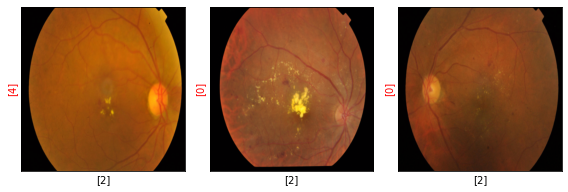

epoch 3


100%|██████████| 46/46 [09:01<00:00, 11.77s/it]


train_acc:0.5166 train_loss:1.1374
epoch 4


100%|██████████| 46/46 [09:06<00:00, 11.89s/it]


train_acc:0.5547 train_loss:1.0995


100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


valid_acc:0.5188 valid_loss:1.2241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


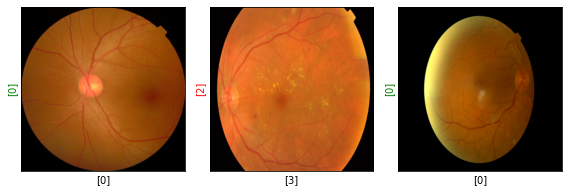

epoch 5


100%|██████████| 46/46 [08:48<00:00, 11.49s/it]


train_acc:0.5387 train_loss:1.1232
epoch 6


100%|██████████| 46/46 [09:03<00:00, 11.82s/it]


train_acc:0.5605 train_loss:1.0784


100%|██████████| 10/10 [01:38<00:00,  9.89s/it]


valid_acc:0.5141 valid_loss:1.3340


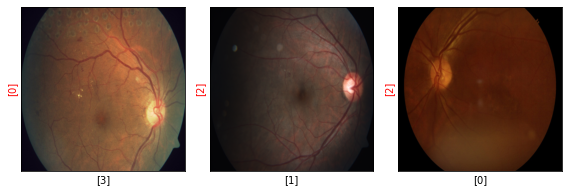

epoch 7


  2%|▏         | 1/46 [00:11<08:25, 11.24s/it]

In [ ]:
train(train_dl, valid_dl, 20)

# Validation dataloader metrics

In [115]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [116]:
prediction = []
original = []
image = []

In [118]:
for tb, (images, labels) in enumerate(tqdm(valid_dl)):
  model.eval()
  images, labels = images.to(device), labels.to(device)
  acts = model(images)
  preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
  image.append(images.permute(0,2,3,1).cpu().numpy())
  original.extend(labels.tolist())
  prediction.extend(preds.tolist())

100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


In [119]:
len(prediction), len(original)

(640, 640)

In [120]:
image = np.vstack(image)

In [121]:
score = accuracy_score(original,prediction)
score

0.5296875

In [122]:
vocab

OrderedDict([('NoDR', 0),
             ('Mild', 1),
             ('Moderate', 2),
             ('Severe', 3),
             ('ProliferativeDR', 4)])

In [123]:
confusion_matrix(original,prediction)

array([[163,   2,   9,   3,   0],
       [ 21,  55,  30,   0,   0],
       [ 17,  33, 111,   4,   8],
       [  4,  26,  46,   2,   6],
       [ 13,  23,  53,   3,   8]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

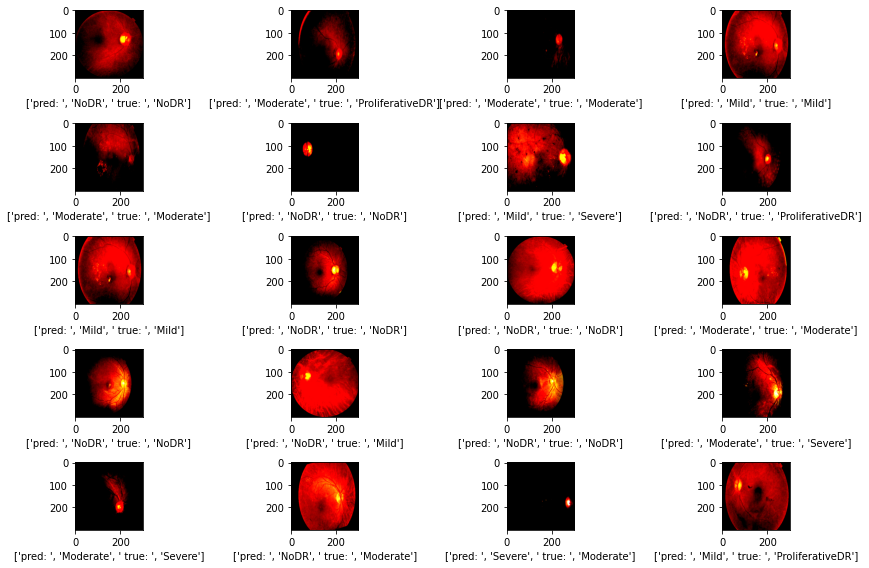

In [125]:
fig = plt.figure(figsize = (12,8))
for i in range(20):
    j = random.randint(0,len(image))
    plt.subplot(5, 4, i+1)
    plt.xlabel("pred: " + L(vocab)[prediction[j]] +" true: " + L(vocab)[original[j]])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

# Inference

In [126]:
test_pth = Path("test_images")

In [185]:
test_df = pd.read_csv("test.csv")

In [186]:
test_data = test_df.to_records(index=False)
test_data

rec.array([('0005cfc8afb6',), ('003f0afdcd15',), ('006efc72b638',), ...,
           ('ff64897ac0d8',), ('ffa73465b705',), ('ffdc2152d455',)],
          dtype=[('id_code', 'O')])

In [187]:
test_ds = APTOSDataset(test_data, pth=test_pth, augs=valid_augs, test=True)

In [188]:
test_ds[1]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [204]:
def collate_test(b):
  batch = list(zip(*b))
  images = torch.stack(batch[0], 0)
  labels = None
  return images, labels

In [205]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, drop_last=False, collate_fn=collate_test)

In [206]:
tt = next(iter(test_dl))

In [209]:
tt[0].shape, tt[1]

(torch.Size([64, 3, 300, 300]), None)

In [213]:
@torch.no_grad()
def infer(test_dl, model):
  model.eval()
  result = []
  l_valid = len(test_dl)
  for vb, (images, labels) in enumerate(tqdm(test_dl)):
    images = images.to(device)
    acts = model(images)
    preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
    result.extend(preds.squeeze().tolist())
  return result

In [214]:
result = infer(test_dl, model)

100%|██████████| 31/31 [02:19<00:00,  4.50s/it]


In [215]:
sub = {'id_code': test_df.id_code,
       'diagnosis': result}

In [216]:
sub = pd.DataFrame(sub)
sub.to_csv('submission.csv', index=False)

In [218]:
sub.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,1
3,00836aaacf06,1
4,009245722fa4,2
